In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [2]:
# Set seed for Python's built-in random number generator

# Set seed for numpy. Put your SID instead of number '42'
np.random.seed(2271002) 
# Set seed for Python's built-in random number generator.  Put your SID instead of number '42'
random.seed(2271002)

# Set seed for TensorFlow tf.random.set_seed(42)
# Put your SID instead of number '42'
tf.random.set_seed(2271002)

K.clear_session() # Set seed for Keras

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, 
              #verbose=0,
             verbose=1)
    return model

## 2 Clients

In [7]:
# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, 
                                                                  #random_state=42,
                                                  # Put your SID instead of number '42'                
                                                                  random_state= 2167288
                                                                 )

In [8]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [9]:
# Create and train client models

client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)


Epoch 1/5


938/938 [==============================] - 2s 2ms/step - loss: 0.3436 - accuracy: 0.9029
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1584 - accuracy: 0.9537
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1079 - accuracy: 0.9665
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0817 - accuracy: 0.9753
Epoch 5/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0624 - accuracy: 0.9811
Epoch 1/5
938/938 [==============================] - 2s 1ms/step - loss: 0.3364 - accuracy: 0.9042
Epoch 2/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1581 - accuracy: 0.9532
Epoch 3/5
938/938 [==============================] - 1s 1ms/step - loss: 0.1099 - accuracy: 0.9681
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0822 - accuracy: 0.9762
Epoch 5/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0637 - accuracy: 0.9813


In [10]:
# Federated averaging

def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [11]:
# Aggregate models

aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [12]:
# Create global model and set weights

global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [13]:
# Evaluate global model

test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 0.4020 - accuracy: 0.8869 - 471ms/epoch - 2ms/step
Test accuracy: 0.886900007724762


In [14]:
test_accuracy = []

In [15]:
test_accuracy.append(0.8851000070571899)

In [16]:
test_accuracy

[0.8851000070571899]

#### Write your code to calculate precision, recall, and F-score


In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 850us/step
(10000, 10)


In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       980
           1       0.95      0.99      0.97      1135
           2       0.93      0.85      0.89      1032
           3       0.80      0.96      0.87      1010
           4       0.85      0.93      0.89       982
           5       0.71      0.97      0.82       892
           6       1.00      0.73      0.85       958
           7       0.86      0.94      0.90      1028
           8       0.93      0.80      0.86       974
           9       0.97      0.82      0.89      1009

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [20]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

Accuracy test set:  0.8869
Precision test set:  0.9013498012642552
Recall test set:  0.8869
F-score test set:  0.887569571348198


In [21]:
test_precision = []
test_recall    = []
test_f1_score  = []

In [22]:
test_precision.append(0.907323157047967)
test_recall.append(0.8851)
test_f1_score.append(0.8851514824563385)

#### Display confusion matrix between actual and predicted values on the test data.


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

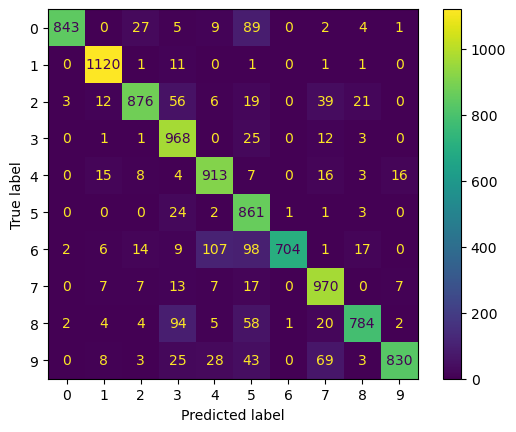

In [24]:
# display confusion matrix between test output and predicted output

cm = confusion_matrix(y_test, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
#plt.show()

## 4 Clients

In [25]:
# Split data into 4 clients

In [26]:
Client_1 = (x_train[0:15000], y_train[0:15000])
Client_2 = (x_train[15000:30000], y_train[15000:30000])
Client_3 = (x_train[30000:45000], y_train[30000:45000])
Client_4 = (x_train[45000:], y_train[45000:])

In [27]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [28]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.4457 - accuracy: 0.8759
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2121 - accuracy: 0.9413
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1468 - accuracy: 0.9595
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1094 - accuracy: 0.9686
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0851 - accuracy: 0.9757
Epoch 1/5
469/469 [==============================] - 2s 2ms/step - loss: 2.3156 - accuracy: 0.1024
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2981 - accuracy: 0.1188
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2880 - accuracy: 0.1282
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2760 - accuracy: 0.1427
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2569 - accuracy: 0.1554
Epoch 1/5


In [29]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weights3, weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights


In [30]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [31]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 0s - loss: 2.2353 - accuracy: 0.3754 - 468ms/epoch - 1ms/step
Test accuracy: 0.37540000677108765


In [32]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 865us/step
(10000, 10)


In [33]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

Accuracy test set:  0.3754
Precision test set:  0.4528993264681874
Recall test set:  0.3754
F-score test set:  0.3521418686835817
              precision    recall  f1-score   support

           0       0.78      0.66      0.71       980
           1       0.67      0.28      0.40      1135
           2       0.39      0.45      0.41      1032
           3       0.67      0.53      0.59      1010
           4       0.37      0.17      0.23       982
           5       0.49      0.18      0.27       892
           6       0.36      0.55      0.44       958
           7       0.20      0.84      0.33      1028
           8       0.29      0.04      0.07       974
           9       0.28      0.03      0.05      1009

    accuracy                           0.38     10000
   macro avg       0.45      0.37      0.35     10000
weighted avg       0.45      0.38      0.35     10000



In [34]:
test_accuracy.append(0.28790000081062317)
test_precision.append(0.37310911314701634)
test_recall.append(0.2879)
test_f1_score.append(0.2500357846568731)

In [35]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317]
[0.907323157047967, 0.37310911314701634]
[0.8851, 0.2879]
[0.8851514824563385, 0.2500357846568731]


## 6 Clients

In [36]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [37]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 0.5157 - accuracy: 0.8583
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 0.2435 - accuracy: 0.9315
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1774 - accuracy: 0.9510
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1392 - accuracy: 0.9592
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1052 - accuracy: 0.9714
Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 2.3190 - accuracy: 0.0981
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2941 - accuracy: 0.1241
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2824 - accuracy: 0.1363
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2643 - accuracy: 0.1518
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2410 - accuracy: 0.1711
Epoch 1/5


In [38]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [39]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.9821 - accuracy: 0.6832 - 447ms/epoch - 1ms/step
Test accuracy: 0.6832000017166138
313/313 [==============================] - 0s 836us/step
(10000, 10)
Accuracy test set:  0.6832
Precision test set:  0.7471835223638127
Recall test set:  0.6832
F-score test set:  0.6698766635117857
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       980
           1       0.90      0.97      0.93      1135
           2       0.66      0.88      0.76      1032
           3       0.48      0.55      0.51      1010
           4       0.97      0.41      0.58       982
           5       0.50      0.94      0.65       892
           6       0.96      0.71      0.82       958
           7       0.56      0.84      0.67      1028
           8       0.92      0.24      0.38       974
           9       0.55      0.40      0.46      1009

    accuracy                           0.68     10000
   macro avg       0.75      0.68      0.67  

In [40]:
test_accuracy.append(0.7271999716758728)
test_precision.append(0.7834205071021751)
test_recall.append(0.7272)
test_f1_score.append(0.7308748558259915)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751]
[0.8851, 0.2879, 0.7272]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915]


## 8 Clients

In [41]:
Client_1 = (x_train[0:7500], y_train[0:7500])
Client_2 = (x_train[7500:15000], y_train[7500:15000])
Client_3 = (x_train[15000:22500], y_train[15000:22500])
Client_4 = (x_train[22500:30000], y_train[22500:30000])
Client_5 = (x_train[30000:37500], y_train[30000:37500])
Client_6 = (x_train[37500:45000], y_train[37500:45000])
Client_7 = (x_train[45000:52500], y_train[45000:52500])
Client_8 = (x_train[52500:], y_train[52500:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Epoch 1/5
235/235 [==============================] - 1s 1ms/step - loss: 0.5794 - accuracy: 0.8424
Epoch 2/5
235/235 [==============================] - 0s 1ms/step - loss: 0.2549 - accuracy: 0.9275
Epoch 3/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1901 - accuracy: 0.9444
Epoch 4/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1428 - accuracy: 0.9612
Epoch 5/5
235/235 [==============================] - 0s 1ms/step - loss: 0.1122 - accuracy: 0.9692
Epoch 1/5
235/235 [==============================] - 1s 1ms/step - loss: 2.3238 - accuracy: 0.1097
Epoch 2/5
235/235 [==============================] - 0s 1ms/step - loss: 2.2894 - accuracy: 0.1331
Epoch 3/5
235/235 [==============================] - 0s 1ms/step - loss: 2.2665 - accuracy: 0.1484


In [42]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, 
                              weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4, 
                                              weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 +w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [43]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.8690 - accuracy: 0.6475 - 429ms/epoch - 1ms/step
Test accuracy: 0.6474999785423279
313/313 [==============================] - 0s 844us/step
(10000, 10)
Accuracy test set:  0.6475
Precision test set:  0.7658515094265492
Recall test set:  0.6475
F-score test set:  0.6225808163963383
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       980
           1       1.00      0.47      0.64      1135
           2       0.47      0.92      0.63      1032
           3       0.51      0.91      0.65      1010
           4       0.77      0.93      0.85       982
           5       0.44      0.82      0.57       892
           6       1.00      0.43      0.60       958
           7       0.77      0.80      0.78      1028
           8       0.95      0.23      0.38       974
           9       0.78      0.15      0.25      1009

    accuracy                           0.65     10000
   macro avg       0.76      0.65      0.62  

In [44]:
test_accuracy.append(0.6028000116348267)
test_precision.append(0.7986126719530607)
test_recall.append(0.6028)
test_f1_score.append(0.5536289939655649)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607]
[0.8851, 0.2879, 0.7272, 0.6028]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649]


## 10 Clients

In [45]:
Client_1 = (x_train[0:6000], y_train[0:6000])
Client_2 = (x_train[6000:12000], y_train[6000:12000])
Client_3 = (x_train[12000:18000], y_train[12000:18000])
Client_4 = (x_train[18000:24000], y_train[18000:24000])
Client_5 = (x_train[24000:30000], y_train[24000:30000])
Client_6 = (x_train[30000:36000], y_train[30000:36000])
Client_7 = (x_train[36000:42000], y_train[36000:42000])
Client_8 = (x_train[42000:48000], y_train[42000:48000])
Client_9 = (x_train[48000:54000], y_train[48000:54000])
Client_10 = (x_train[54000:], y_train[54000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)
print(Client_9[0].shape)
print(Client_10[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)
print(Client_9[1].shape)
print(Client_10[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])
client9_model = train_client_model(client9_model, Client_9[0], Client_9[1])
client10_model = train_client_model(client10_model, Client_10[0], Client_10[1])

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
Epoch 1/5
188/188 [==============================] - 1s 1ms/step - loss: 0.6156 - accuracy: 0.8315
Epoch 2/5
188/188 [==============================] - 0s 1ms/step - loss: 0.2717 - accuracy: 0.9270
Epoch 3/5
188/188 [==============================] - 0s 1ms/step - loss: 0.2024 - accuracy: 0.9455
Epoch 4/5
188/188 [==============================] - 0s 1ms/step - loss: 0.1578 - accuracy: 0.9562
Epoch 5/5
188/188 [==============================] - 0s 1ms/step - loss: 0.1226 - accuracy: 0.9687
Epoch 1/5
188/188 [==============================] - 1s 1ms/step - loss: 2.3242 - accuracy: 0.1038
Epoch 2/5
188/188 [==============================] - 0s 1ms/step - loss: 2.2844 - accuracy: 0.1392
Epoch 3/5
188/188 [============================

In [46]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5,
                              weights6, weights7, weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2, weights3, weights4, 
                                                      weights5, weights6, weights7, weights8, 
                                                      weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights(),
                                               client9_model.get_weights(),
                                               client10_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [47]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.8150 - accuracy: 0.6171 - 458ms/epoch - 1ms/step
Test accuracy: 0.6171000003814697
313/313 [==============================] - 0s 858us/step
(10000, 10)
Accuracy test set:  0.6171
Precision test set:  0.8359434140127739
Recall test set:  0.6171
F-score test set:  0.5876643462265703
              precision    recall  f1-score   support

           0       0.97      0.57      0.72       980
           1       0.99      0.82      0.90      1135
           2       0.86      0.88      0.87      1032
           3       0.96      0.18      0.30      1010
           4       0.89      0.79      0.84       982
           5       0.27      0.97      0.42       892
           6       0.94      0.84      0.89       958
           7       0.47      0.98      0.63      1028
           8       1.00      0.05      0.10       974
           9       0.96      0.08      0.15      1009

    accuracy                           0.62     10000
   macro avg       0.83      0.62      0.58  

In [48]:
test_accuracy.append(0.6428999900817871)
test_precision.append(0.8044962589008876)
test_recall.append(0.6429)
test_f1_score.append(0.6203729491096158)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876]
[0.8851, 0.2879, 0.7272, 0.6028, 0.6429]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]


### Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

In [49]:
import pandas as pd

In [50]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871], [0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876], [0.8851, 0.2879, 0.7272, 0.6028, 0.6429], [0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]]


Accuracy  Precision  Recall  F1_Score
2     0.8851   0.907323  0.8851  0.885151
4     0.2879   0.373109  0.2879  0.250036
6     0.7272   0.783421  0.7272  0.730875
8     0.6028   0.798613  0.6028  0.553629
10    0.6429   0.804496  0.6429  0.620373

In [51]:
import pandas as pd
import matplotlib.pyplot as plt 

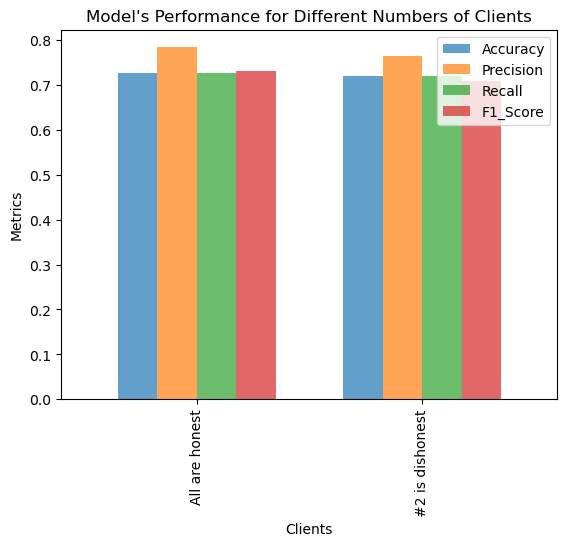

In [67]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

# Setting plot title and labels
plt.title("Model's Performance for Different Numbers of Clients")
plt.xlabel("Clients")
plt.ylabel("Metrics")

# Show the plot
plt.show()

### 2.For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.

#### Take 6 Clients, one of them is assumed dishonest



In [53]:
# Split data into 6 clients

In [54]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

In [55]:
Client_2[1].size

10000

In [56]:
Client_2[1]

array([3, 8, 7, ..., 1, 4, 2], dtype=uint8)

In [57]:
### Client_2 is assumed dishonest and changing the training data. Some labels are set as 4 
### Change the first 2000 labels

Client_2[1][:2000] = 4

In [58]:
Client_2[1]

array([4, 4, 4, ..., 1, 4, 2], dtype=uint8)

In [59]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [60]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.8568
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 0.2375 - accuracy: 0.9357
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1720 - accuracy: 0.9523
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.9624
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.1002 - accuracy: 0.9725
Epoch 1/5
313/313 [==============================] - 1s 1ms/step - loss: 2.3202 - accuracy: 0.0960
Epoch 2/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2946 - accuracy: 0.1218
Epoch 3/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2822 - accuracy: 0.1344
Epoch 4/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2620 - accuracy: 0.1560
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 2.2372 - accuracy: 0.1709
Epoch 1/5


In [61]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [62]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 0s - loss: 1.9491 - accuracy: 0.7391 - 455ms/epoch - 1ms/step
Test accuracy: 0.7390999794006348
313/313 [==============================] - 0s 872us/step
(10000, 10)
Accuracy test set:  0.7391
Precision test set:  0.7721905425431017
Recall test set:  0.7391
F-score test set:  0.7294477945612121
              precision    recall  f1-score   support

           0       0.86      0.92      0.88       980
           1       0.74      0.99      0.85      1135
           2       0.85      0.48      0.61      1032
           3       0.52      0.93      0.67      1010
           4       0.89      0.80      0.84       982
           5       0.72      0.61      0.66       892
           6       0.84      0.83      0.83       958
           7       0.68      0.81      0.74      1028
           8       0.74      0.65      0.69       974
           9       0.89      0.36      0.51      1009

    accuracy                           0.74     10000
   macro avg       0.77      0.74      0.73  

In [63]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [64]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.7197999954223633)
test_precision_dishonest.append(0.7649681801937827)
test_recall_dishonest.append(0.7198)
test_f1_score_dishonest.append(0.7079021148713025)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.7271999716758728, 0.7197999954223633]
[0.7834205071021751, 0.7649681801937827]
[0.7272, 0.7198]
[0.7308748558259915, 0.7079021148713025]


In [65]:
### Plot the model's performance for the 6 clients, one of them (number=2) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#2 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.7271999716758728, 0.7197999954223633], [0.7834205071021751, 0.7649681801937827], [0.7272, 0.7198], [0.7308748558259915, 0.7079021148713025]]


Accuracy  Precision  Recall  F1_Score
All are honest     0.7272   0.783421  0.7272  0.730875
#2 is dishonest    0.7198   0.764968  0.7198  0.707902

Text(0.5, 1.0, "Model's Performance with Dishonest Clients")

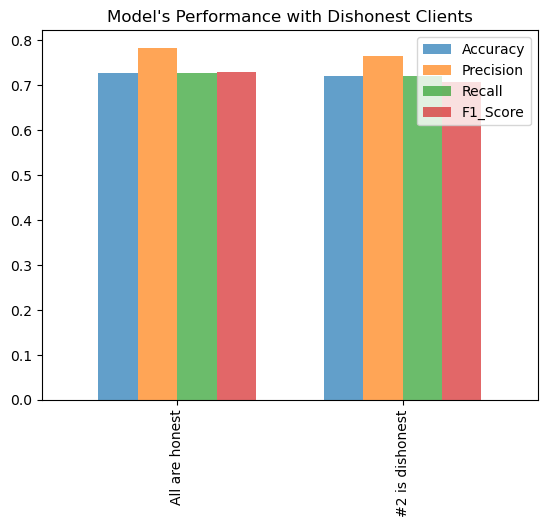

In [66]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.title("Model's Performance with Dishonest Clients")